## Modelo Preditivo do Prophet
- Propeht usa um modelo de séries temporais decomposto, com três componentes principais: tendência, sazonalidade e feriados:
                              y(1) = g(t) + s(t)+ h(t) + E,
- onde:
    - g(t) é a tendência, que modela as mudanças não-periódicas no valor da série temporal;
    - s(t) representa as mudanças periódicas (como sazonalidade semanal, anual, etc);
    - h(t) representa os efeitos dos feriados; e
    - E, é o erro, as mudanças que não são capturadas pelo modelo (assume-se esse como tendo uma distribuição normal).

In [203]:

# Importar bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import joblib

In [204]:
df = pd.read_csv('2024-07-02_ipea.csv', encoding='iso-8859-1')
df.head()

,ï»¿,Data,Preco_petroleo_bruto_Brent_FOB
0,0,2024-05-20T00:00:00.000,81.91
1,1,2024-05-17T00:00:00.000,82.24
2,2,2024-05-16T00:00:00.000,81.65
3,3,2024-05-15T00:00:00.000,79.98
4,4,2024-05-14T00:00:00.000,81.00


In [205]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11174 entries, 0 to 11173
Data columns (total 3 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ï»¿                             11174 non-null  int64  
 1   Data                            11174 non-null  object 
 2   Preco_petroleo_bruto_Brent_FOB  11174 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 262.0+ KB


In [206]:
# Renomeando as colunas
df.rename(columns={'ï»¿': 'ID', 'Preco_petroleo_bruto_Brent_FOB': 'Preco'}, inplace = True)
df

,ID,Data,Preco
0,0,2024-05-20T00:00:00.000,81.91
1,1,2024-05-17T00:00:00.000,82.24
2,2,2024-05-16T00:00:00.000,81.65
3,3,2024-05-15T00:00:00.000,79.98
4,4,2024-05-14T00:00:00.000,81.00
...,...,...,...
11169,11169,1987-05-26T00:00:00.000,18.63
11170,11170,1987-05-25T00:00:00.000,18.60
11171,11171,1987-05-22T00:00:00.000,18.55
11172,11172,1987-05-21T00:00:00.000,18.45


In [207]:
#Dropando o campo ID
df.drop(['ID'], axis=1, inplace=True)
df

,Data,Preco
0,2024-05-20T00:00:00.000,81.91
1,2024-05-17T00:00:00.000,82.24
2,2024-05-16T00:00:00.000,81.65
3,2024-05-15T00:00:00.000,79.98
4,2024-05-14T00:00:00.000,81.00
...,...,...
11169,1987-05-26T00:00:00.000,18.63
11170,1987-05-25T00:00:00.000,18.60
11171,1987-05-22T00:00:00.000,18.55
11172,1987-05-21T00:00:00.000,18.45


In [208]:
df.shape

(11174, 2)

In [209]:
# Verificando se há dados nulos
df.isnull().sum()

Data     0
Preco    0
dtype: int64

In [210]:
df.describe().round(2)

,Preco
count,11174.00
mean,53.04
std,33.23
min,9.10
25%,20.50
50%,48.26
75%,76.44
max,143.95


In [211]:
#Convertendo o campo data para datetime
df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
df

,Data,Preco
0,2024-05-20,81.91
1,2024-05-17,82.24
2,2024-05-16,81.65
3,2024-05-15,79.98
4,2024-05-14,81.00
...,...,...
11169,1987-05-26,18.63
11170,1987-05-25,18.60
11171,1987-05-22,18.55
11172,1987-05-21,18.45


In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11174 entries, 0 to 11173
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    11174 non-null  datetime64[ns]
 1   Preco   11174 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 174.7 KB


In [213]:
# Preparando os dados para usar a biblioteca Prophet
df_prophet = df.rename(columns={'Data': 'ds', 'Preco': 'y'})
df_prophet


,ds,y
0,2024-05-20,81.91
1,2024-05-17,82.24
2,2024-05-16,81.65
3,2024-05-15,79.98
4,2024-05-14,81.00
...,...,...
11169,1987-05-26,18.63
11170,1987-05-25,18.60
11171,1987-05-22,18.55
11172,1987-05-21,18.45


In [214]:
#Ordenanando as datas da antiga para a atual
df_prophet.sort_index(ascending=False, inplace=True)
df_prophet

,ds,y
11173,1987-05-20,18.63
11172,1987-05-21,18.45
11171,1987-05-22,18.55
11170,1987-05-25,18.60
11169,1987-05-26,18.63
...,...,...
4,2024-05-14,81.00
3,2024-05-15,79.98
2,2024-05-16,81.65
1,2024-05-17,82.24


In [215]:
feriados = pd.DataFrame({
    'holiday': 'Crise',
    'ds': pd.to_datetime(['2008-07-07', '2014-06-01', '2020-02-01', '2022-01-01']),
    'lower_window': 0,
    'upper_window': 1,
})

In [216]:
feriados

,holiday,ds,lower_window,upper_window
0,Crise,2008-07-07,0,1
1,Crise,2014-06-01,0,1
2,Crise,2020-02-01,0,1
3,Crise,2022-01-01,0,1


# Modelo 1  - sem feriados - Gerando a previsao para os proximos 365 dias sem os dados de treino ou teste ou feriados

In [217]:
# Startando o modelo
model = Prophet()

In [218]:
#Fazendoo ajuste no modelo como o fit
model.fit(df_prophet)

22:14:17 - cmdstanpy - INFO - Chain [1] start processing
22:14:27 - cmdstanpy - INFO - Chain [1] done processing


In [228]:
#Gerando um dataframe com datas do futuro com um periodo de 1 ano
future = model.make_future_dataframe(periods=365)

In [229]:
#Gerando as previsoes
forecast = model.predict(future)

In [230]:
# Verificar as previsões
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

              ds       yhat  yhat_lower  yhat_upper
11534 2025-05-16  96.961499   82.380585  111.625937
11535 2025-05-17  97.445380   82.715406  112.123492
11536 2025-05-18  96.903682   81.738855  111.975226
11537 2025-05-19  97.119663   83.199374  111.197652
11538 2025-05-20  97.089725   82.597163  112.100876


/Users/decassia/.conda/envs/anp_data/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/decassia/.conda/envs/anp_data/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/decassia/.conda/envs/anp_data/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/decassia

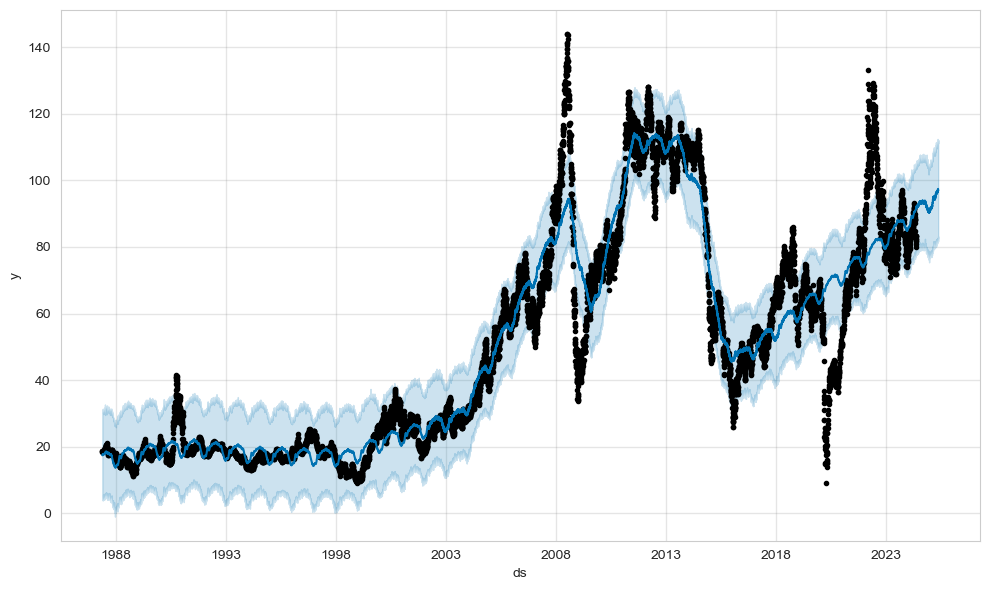

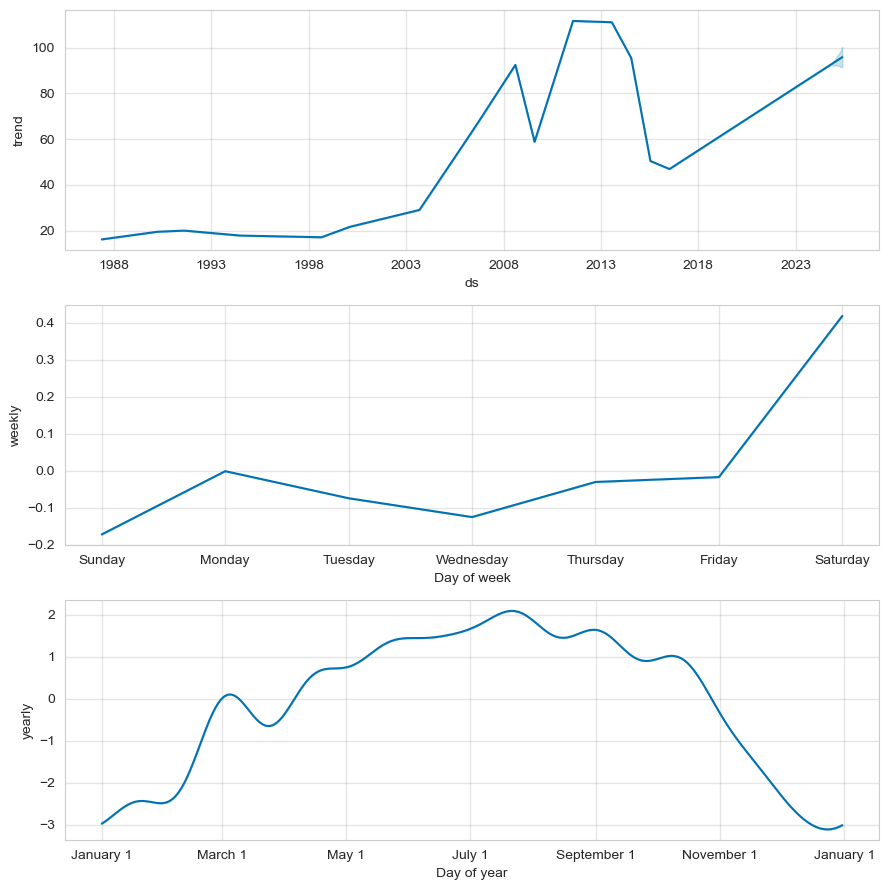

In [231]:
# Visualizar as previsões
fig = model.plot(forecast)
#grafico de componentes com as tendencias 
fig = model.plot_components(forecast)
#plt.show()

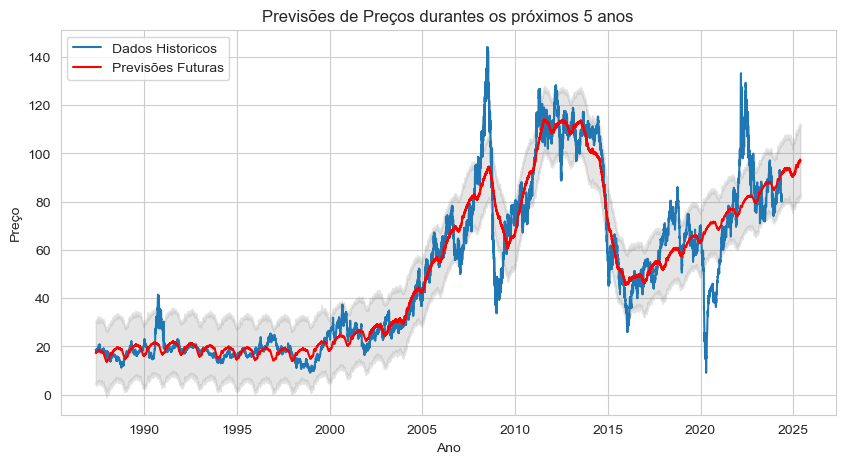

In [232]:
# Visualizar os resultados das previsões
plt.figure(figsize=(10, 5))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Dados Historicos')
plt.plot(forecast['ds'], forecast['yhat'], label='Previsões Futuras', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)
plt.xlabel('Ano')
plt.ylabel('Preço')
plt.title('Previsões de Preços durantes ano - 365 dias ')
plt.legend()
plt.show()

## Avaliando o modelo

In [377]:
mae = np.mean(np.abs(df_prophet['y'] - forecast['yhat']))
rmse = np.sqrt(mean_squared_error(df_prophet['y'] , forecast['yhat']))

In [378]:
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 54.02588172936787
Root Mean Squared Error (RMSE): 15.241780697279411


## Modelo 2 - Gerando previsao com dados de treino e teste 
- Para entender se realmente a previsao anterior coincide 

In [484]:
df_prophet_ = df.rename(columns={'Data': 'ds', 'Preco': 'y'})
df_prophet_

,ds,y
0,2024-05-20,81.91
1,2024-05-17,82.24
2,2024-05-16,81.65
3,2024-05-15,79.98
4,2024-05-14,81.00
...,...,...
11169,1987-05-26,18.63
11170,1987-05-25,18.60
11171,1987-05-22,18.55
11172,1987-05-21,18.45


In [500]:
# Divisão dos Dados em Treino e Teste com uma data de corte
cut_date = '2020-12-31'

# Dados de treino
train_df = df_prophet_[df_prophet_['ds'] <= cut_date]
train_df.head()
# Dados de teste
test_df = df_prophet_[df_prophet_['ds'] > cut_date]


In [501]:
# Verificando os tamanhos dos conjuntos de treino e teste
print("Treino:", train_df.shape)
print("Teste:", test_df.shape)


Treino: (10316, 2)
Teste: (858, 2)


In [502]:
train_df

,ds,y
858,2020-12-31,51.22
859,2020-12-30,50.74
860,2020-12-29,50.44
861,2020-12-28,50.88
862,2020-12-24,50.88
...,...,...
11169,1987-05-26,18.63
11170,1987-05-25,18.60
11171,1987-05-22,18.55
11172,1987-05-21,18.45


In [503]:
test_df

,ds,y
0,2024-05-20,81.91
1,2024-05-17,82.24
2,2024-05-16,81.65
3,2024-05-15,79.98
4,2024-05-14,81.00
...,...,...
853,2021-01-08,55.51
854,2021-01-07,53.70
855,2021-01-06,53.80
856,2021-01-05,53.16


In [504]:

# Verificando se os conjuntos de treino e teste não estão vazios
if train_df.empty or test_df.empty:
    raise ValueError("Os conjuntos de treino ou teste estão vazios. Verifique a data de corte e os dados.")

In [505]:
# Treinamento do Modelo Prophet
model2 = Prophet()
model2.fit(train_df)

12:07:13 - cmdstanpy - INFO - Chain [1] start processing
12:07:27 - cmdstanpy - INFO - Chain [1] done processing


In [506]:

# Fazer previsões para os próximos anos (igual ao tamanho do conjunto de teste)
future = model2.make_future_dataframe(periods=len(test_df))

# Verificar o intervalo das datas futuras
print("Datas futuras geradas:")
print(future.tail())


Datas futuras geradas:
              ds
11169 2023-05-04
11170 2023-05-05
11171 2023-05-06
11172 2023-05-07
11173 2023-05-08


In [507]:
# Garantir que as datas futuras estão dentro do intervalo esperado
if future['ds'].max() > pd.to_datetime('2025-01-01'):
    raise ValueError("As datas previstas estão fora do intervalo esperado. Verifique o número de períodos.")


In [508]:
forecast2 = model.predict(future)

In [509]:
# Comparar as previsões com os dados reais
forecast_test = forecast2[forecast2['ds'] > cut_date]
print("\nDatas previstas após a data de corte:")
print(forecast_test['ds'])


Datas previstas após a data de corte:
10316   2021-01-01
10317   2021-01-02
10318   2021-01-03
10319   2021-01-04
10320   2021-01-05
           ...    
11169   2023-05-04
11170   2023-05-05
11171   2023-05-06
11172   2023-05-07
11173   2023-05-08
Name: ds, Length: 858, dtype: datetime64[ns]


In [510]:
#Fazendo um merge entre os dados
#merged = test_df.merge(forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')
merged = test_df.merge(forecast_test[['ds', 'yhat']], on='ds')


In [511]:
merged.head()

,ds,y,yhat
0,2023-05-05,75.85,40.645938
1,2023-05-04,73.00,40.685432
2,2023-05-03,72.91,40.536802
3,2023-05-02,76.71,40.565087
4,2023-04-28,81.32,40.547077


In [512]:
# Verificar se a mesclagem resultou em dados válidos
if merged.empty:
    raise ValueError("A mesclagem dos dados de teste e previsões resultou em um DataFrame vazio. Verifique os dados.")


In [513]:
# Calcular métricas de avaliação
mae = np.mean(np.abs(merged['y'] - merged['yhat']))
rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))
mean_test_value = test_df['y'].mean()

In [514]:
#Printado as avaliacoes
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Value of Test Dataset: {mean_test_value}')

Mean Absolute Error (MAE): 41.717174845196475
Root Mean Squared Error (RMSE): 45.55649312339998
Mean Value of Test Dataset: 84.70854312354311


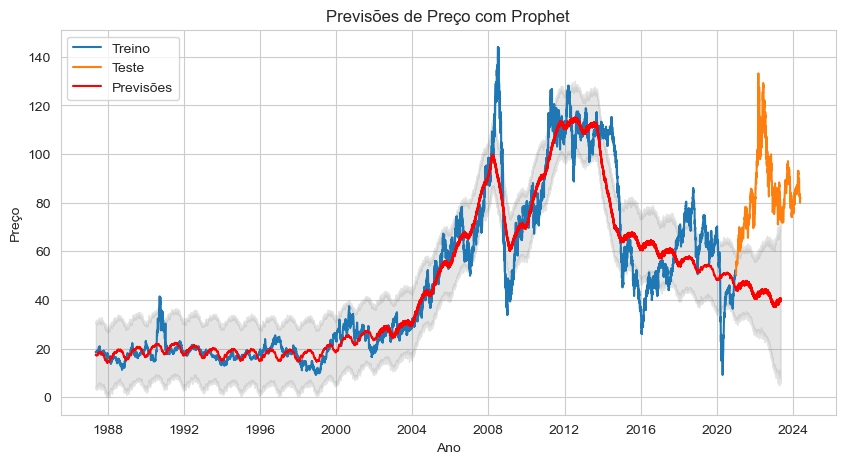

In [515]:
# Visualizar os resultados das previsões
plt.figure(figsize=(10, 5))
plt.plot(train_df['ds'], train_df['y'], label='Treino')
plt.plot(test_df['ds'], test_df['y'], label='Teste')
plt.plot(forecast2['ds'], forecast2['yhat'], label='Previsões', color='red')
plt.fill_between(forecast2['ds'], forecast2['yhat_lower'], forecast2['yhat_upper'], color='gray', alpha=0.2)
plt.xlabel('Ano')
plt.ylabel('Preço')
plt.title('Previsões para 1 ano')
plt.legend()
plt.show()

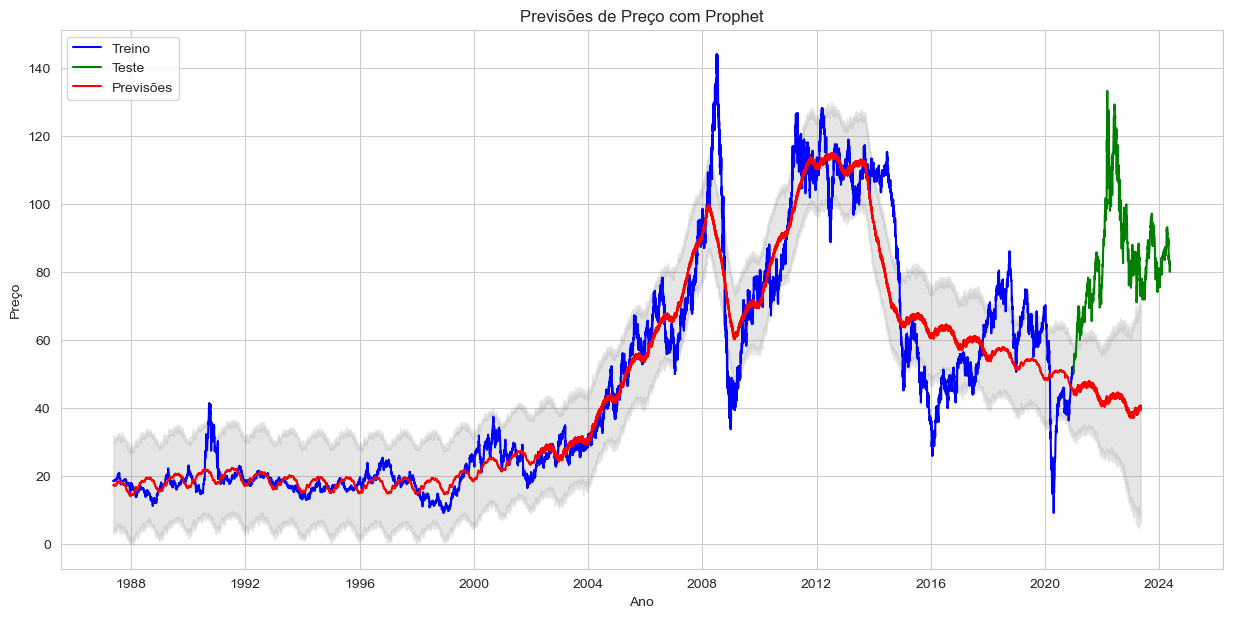

In [516]:
# Visualizar os resultados das previsões
plt.figure(figsize=(15, 7))
plt.plot(train_df['ds'], train_df['y'], label='Treino', color='blue')
plt.plot(test_df['ds'], test_df['y'], label='Teste', color='green')
plt.plot(forecast2['ds'], forecast2['yhat'], label='Previsões', color='red')
plt.fill_between(forecast2['ds'], forecast2['yhat_lower'], forecast2['yhat_upper'], color='gray', alpha=0.2)
plt.xlabel('Ano')
plt.ylabel('Preço')
plt.title('Previsões de Preço com Prophet')
plt.legend()
plt.show()

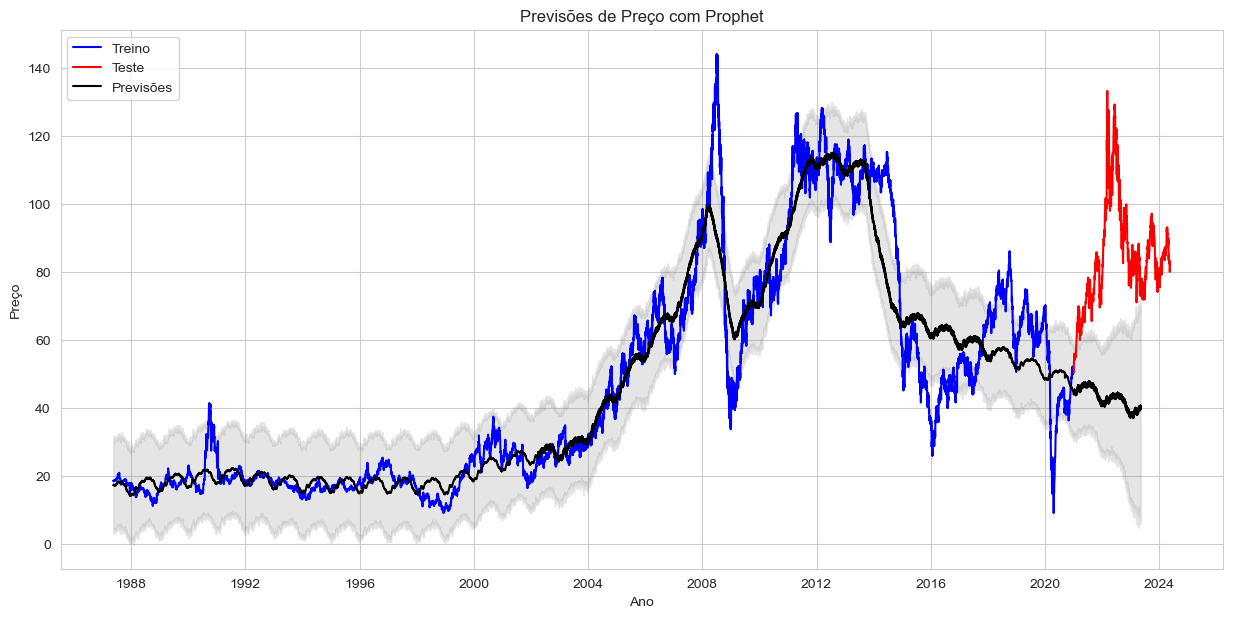

In [517]:
# Visualizar os resultados das previsões
plt.figure(figsize=(15, 7))

# Plotar os dados de treino e teste
plt.plot(train_df['ds'], train_df['y'], label='Treino', color='blue', linestyle='-')
plt.plot(test_df['ds'], test_df['y'], label='Teste', color='red', linestyle='-')

# Plotar as previsões
plt.plot(forecast2['ds'], forecast2['yhat'], label='Previsões', color='black', linestyle='-')

# Adicionar intervalo de confiança
plt.fill_between(forecast2['ds'], forecast2['yhat_lower'], forecast2['yhat_upper'], color='gray', alpha=0.2)

# Configurações do gráfico
plt.xlabel('Ano')
plt.ylabel('Preço')
plt.title('Previsões para 1 ano')
plt.legend()
plt.show()

In [518]:
#Usando o metodo mais simples do profet para plotar os graficos
forecast_tail = forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
print(forecast_tail)

              ds       yhat  yhat_lower  yhat_upper
11169 2023-05-04  40.685432    7.494099   68.314158
11170 2023-05-05  40.645938    8.092462   70.257016
11171 2023-05-06  40.324558    5.812079   68.895308
11172 2023-05-07  39.435254    7.796567   70.560386
11173 2023-05-08  40.724776    7.549006   72.678088


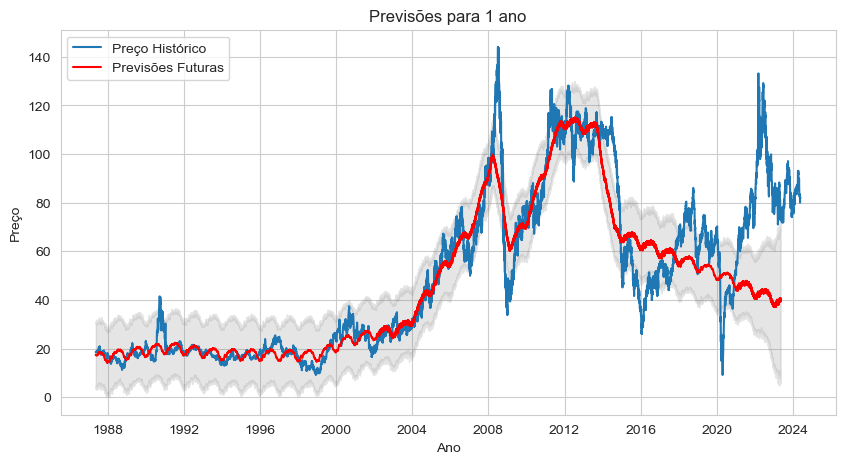

In [520]:
# Plotando os resultados das previsões
plt.figure(figsize=(10, 5))
plt.plot(df_prophet_['ds'], df_prophet_['y'], label='Preço Histórico')
plt.plot(forecast2['ds'], forecast2['yhat'], label='Previsões Futuras', color='red')
plt.fill_between(forecast2['ds'], forecast2['yhat_lower'], forecast2['yhat_upper'], color='gray', alpha=0.2)
plt.xlabel('Ano')
plt.ylabel('Preço')
plt.title('Previsões para 1 ano')
plt.legend()
plt.show()